# Решающее дерево

# Классификация

Первые 5 строк и размер датасета

In [85]:
import numpy as np
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
# df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
#                                   "tan5577/heart-failure-dataset/versions/1",
#                                   "heart.csv")
df = pd.read_csv("heart.csv")

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Обработка категориальных и числовых признаков

In [87]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
binary_features = ['Sex', 'FastingBP', 'ExerciseAngina']
categorical_features = ['ChestPainType', 'RestingECG', 'ST_Slope']

df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

df['Cholesterol'] = df['Cholesterol'].replace(0, df['Cholesterol'].median())
df['RestingBP'] = df['RestingBP'].replace(0, df['RestingBP'].median())

Функция для матрицы ошибок.

In [88]:
def conf_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Heart Disease', 'Heart Disease'],
                yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

Создание препроцессора

In [89]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

Запуск модели от sklearn на обычном бейзлайне без улучшений.

Бейзлайн DecisionTreeClassifier:
Accuracy: 0.7935
ROC-AUC:  0.7910
F1-score: 0.8137
Recall:   0.8137


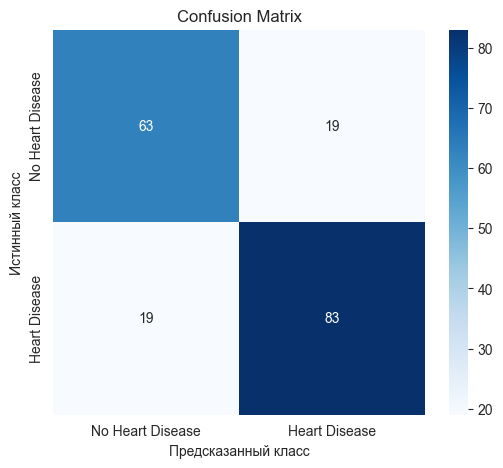

In [90]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tree_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=21))
])

tree_baseline.fit(X_train, y_train)
y_pred = tree_baseline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, tree_baseline.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Бейзлайн DecisionTreeClassifier:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall:   {recall:.4f}")

conf_matrix(y_test, y_pred)

Подберем оптимальные параметры. \
max_depth — ограничивает, насколько глубоким может быть дерево. \
Если None, дерево растёт до тех пор, пока не отделит все объекты (часто приводит к переобучению). \
Ограниченная глубина (например, 10 или 15) делает модель проще и устойчивее к шуму. \
min_samples_split — минимальное число объектов в узле, при котором его ещё можно делить. \
Если в узле всего 2 пациента — делить его рискованно (можно запомнить случайность). \
Значения вроде 5 или 10 заставляют дерево быть "осторожнее". \
min_samples_leaf — минимальное число объектов, которое должно остаться в листе (конечном узле). \
Это предотвращает создание "тонких" листьев с одним-двум выбросами, из-за которых предсказание может сильно скакать. \

In [91]:
tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=21))
])

param_grid = {
    'classifier__max_depth': [None, 5, 10, 15, 20, 25],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(
    tree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (CV):", grid_search.best_score_)

best_params = grid_search.best_params_

Лучшие параметры: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}
Лучший ROC-AUC (CV): 0.8527666246258466


Запустим на тестовых данных

Улучшенный DecisionTreeClassifier:
Accuracy: 0.7935
ROC-AUC:  0.8251
F1-score: 0.8155
Recall:   0.8235


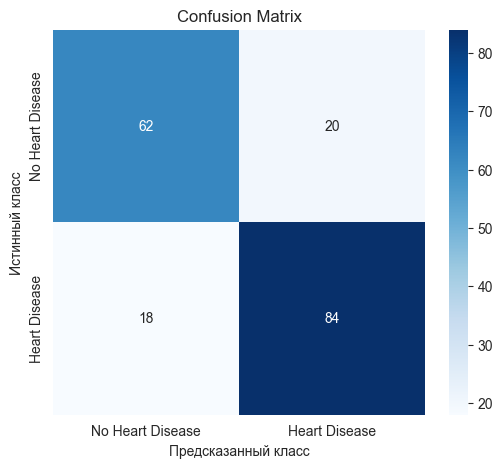

In [92]:
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_tree.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Улучшенный DecisionTreeClassifier:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall:   {recall:.4f}")

conf_matrix(y_pred, y_test)

### Ручная реализация

In [93]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Форма обработанных данных:", X_train_processed.shape)

Форма обработанных данных: (734, 15)


In [94]:
class DecisionTreeNode:
    def __init__(self,
                 feature_idx=None,
                 threshold=None,
                 left=None,
                 right=None,
                 value=None,
                 samples=0):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.samples = samples

class MyDecisionTreeClassifier:
    def __init__(self,
                 max_depth=10,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.root = None

    def _gini(self, y):
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _information_gain(self, y, left_y, right_y):
        if len(left_y) == 0 or len(right_y) == 0:
            return 0
        p = len(left_y) / len(y)
        if self.criterion == 'gini':
            return self._gini(y) - (p * self._gini(left_y) + (1 - p) * self._gini(right_y))
        return 0

    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        n_features = X.shape[1]
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                gain = self._information_gain(y, y[left_mask], y[right_mask])
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)
        node = DecisionTreeNode(samples=n_samples)

        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            len(np.unique(y)) == 1):
            node.value = np.bincount(y).argmax()
            return node

        feature_idx, threshold, gain = self._best_split(X, y)

        if feature_idx is None or gain <= 0:
            node.value = np.bincount(y).argmax()
            return node

        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask

        if (np.sum(left_mask) < self.min_samples_leaf or
            np.sum(right_mask) < self.min_samples_leaf):
            node.value = np.bincount(y).argmax()
            return node

        node.feature_idx = feature_idx
        node.threshold = threshold
        node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return node

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.root = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_sample(x, self.root) for x in X])

    def predict_proba(self, X):
        preds = self.predict(X)
        probas = np.zeros((len(preds), 2))
        for i, p in enumerate(preds):
            probas[i, p] = 1.0
        return probas

Запустим без улучшений и с улучшением.

Ручная реализация DecisionTreeClassifier:
Accuracy: 0.7989
ROC-AUC:  0.7971
F1-score: 0.8177
Recall:   0.8137


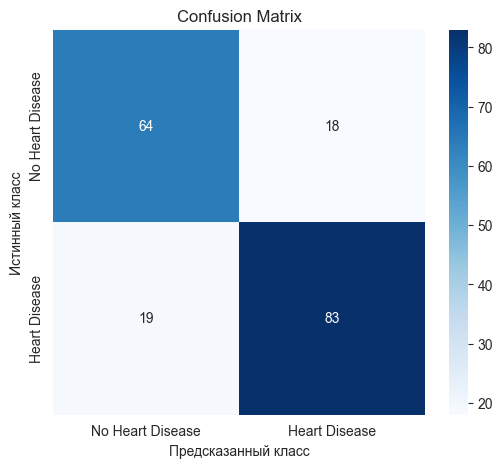


Улучшенная ручная DecisionTreeClassifier:
Accuracy: 0.7826
ROC-AUC:  0.7764
F1-score: 0.8095
Recall:   0.8333


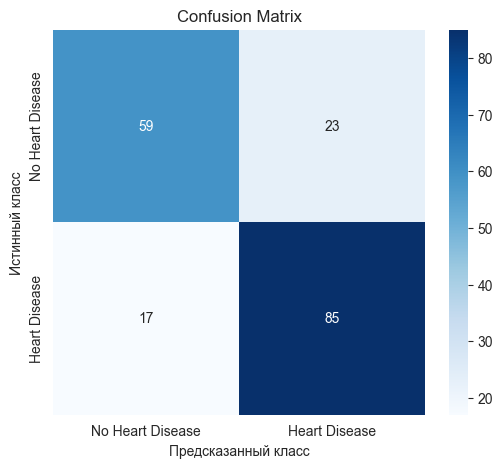

In [95]:
tree_my = MyDecisionTreeClassifier()
tree_my.fit(X_train_processed, y_train)

y_pred_my = tree_my.predict(X_test_processed)
y_proba_my = tree_my.predict_proba(X_test_processed)[:, 1]

acc_my = accuracy_score(y_test, y_pred_my)
roc_auc_my = roc_auc_score(y_test, y_proba_my)
f1_my = f1_score(y_test, y_pred_my)
recall_my = recall_score(y_test, y_pred_my)

print("Ручная реализация DecisionTreeClassifier:")
print(f"Accuracy: {acc_my:.4f}")
print(f"ROC-AUC:  {roc_auc_my:.4f}")
print(f"F1-score: {f1_my:.4f}")
print(f"Recall:   {recall_my:.4f}")

conf_matrix(y_pred_my, y_test)


tree_my_best = MyDecisionTreeClassifier(
    max_depth=best_params['classifier__max_depth'],
    min_samples_split=best_params['classifier__min_samples_split'],
    min_samples_leaf=best_params['classifier__min_samples_leaf']
)
tree_my_best.fit(X_train_processed, y_train)

y_pred_best = tree_my_best.predict(X_test_processed)
y_proba_best = tree_my_best.predict_proba(X_test_processed)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)
f1_best = f1_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)

print(f"\nУлучшенная ручная DecisionTreeClassifier:")
print(f"Accuracy: {acc_best:.4f}")
print(f"ROC-AUC:  {roc_auc_best:.4f}")
print(f"F1-score: {f1_best:.4f}")
print(f"Recall:   {recall_best:.4f}")

conf_matrix(y_pred_best, y_test)

# Регрессия

In [96]:
# df_reg = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
#                                   "kundanbedmutha/exam-score-prediction-dataset",
#                                   "Exam_Score_Prediction.csv")

df_reg = pd.read_csv("Exam_Score_Prediction.csv")

df_reg.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


Обработка категориальных признаков

In [97]:
df_reg['internet_access'] = df_reg['internet_access'].map({'yes': 1, 'no': 0})

sleep_map = {'poor': 0, 'average': 1, 'good': 2}
exam_diff_map = {'easy': 0, 'moderate': 1, 'hard': 2}
facil_diff_map = {'low': 0, 'medium': 1, 'high': 2}

df_reg['sleep_quality'] = df_reg['sleep_quality'].map(sleep_map)
df_reg['exam_difficulty'] = df_reg['exam_difficulty'].map(exam_diff_map)
df_reg['facility_rating'] = df_reg['facility_rating'].map(facil_diff_map)

print("NaN после маппинга:")
print(df_reg[['sleep_quality', 'exam_difficulty', 'facility_rating']].isnull().sum())

NaN после маппинга:
sleep_quality      0
exam_difficulty    0
facility_rating    0
dtype: int64


Как и в прошлой работе визуализируем целевую переменную

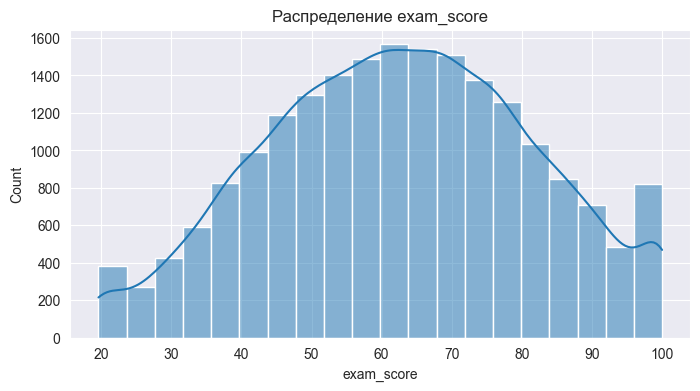

Статистика exam_score:
count    20000.000000
mean        62.513225
std         18.908491
min         19.599000
25%         48.800000
50%         62.600000
75%         76.300000
max        100.000000
Name: exam_score, dtype: float64


In [98]:
plt.figure(figsize=(8, 4))
sns.histplot(df_reg['exam_score'], kde=True, bins=20)
plt.title('Распределение exam_score')
plt.show()

print("Статистика exam_score:")
print(df_reg['exam_score'].describe())

Модель от sklearn

In [99]:
X = df_reg.drop('exam_score', axis=1)
y = df_reg['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
binary_features = ['internet_access']
ordinal_features = ['sleep_quality', 'exam_difficulty', 'facility_rating']
categorical_features = ['gender', 'course', 'study_method']

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ord', 'passthrough', ordinal_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

tree_reg_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', DecisionTreeRegressor())
])

tree_reg_baseline.fit(X_train, y_train)
y_pred_baseline = tree_reg_baseline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae = mean_absolute_error(y_test, y_pred_baseline)
r2 = r2_score(y_test, y_pred_baseline)

print(f"Бейзлайн DecisionTreeRegressor:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"R²:   {r2:.6f}")

Бейзлайн DecisionTreeRegressor:
RMSE: 15.337205
MAE:  12.247665
R²:   0.342377


Подберем гиперпараметры. \
max_features — сколько признаков рассматривать при поиске лучшего разделения. \
'sqrt' — брать корень из общего числа признаков, \
'log2' — ещё меньше, \
None — использовать все.

In [100]:
from sklearn.model_selection import GridSearchCV

lin_reg = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', DecisionTreeRegressor())
])

param_grid = {
    'regressor__max_depth': [None, 3, 5, 7, 10, 15, 20],
    'regressor__min_samples_split': [2, 5, 10, 20],
    'regressor__min_samples_leaf': [1, 2, 5, 10],
    'regressor__max_features': [None, 'sqrt', 'log2']
}

grid_reg = GridSearchCV(
    lin_reg,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_reg.fit(X_train, y_train)

print("Лучшие параметры:", grid_reg.best_params_)
print("Лучший RMSE (CV):", -grid_reg.best_score_)

Лучшие параметры: {'regressor__max_depth': 7, 'regressor__max_features': None, 'regressor__min_samples_leaf': 10, 'regressor__min_samples_split': 2}
Лучший RMSE (CV): 11.445092136055484


In [101]:
best_model = grid_reg.best_estimator_
best_params = grid_reg.best_params_
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\nУлучшенная модель DecisionTreeRegressor:")
print(f"RMSE: {rmse_best:.6f}")
print(f"MAE:  {mae_best:.6f}")
print(f"R²:   {r2_best:.6f}")


Улучшенная модель DecisionTreeRegressor:
RMSE: 11.430209
MAE:  9.235048
R²:   0.634748


### Ручная реализация

In [102]:
import numpy as np

class DecisionTreeNode:
    def __init__(self,
                 feature_idx=None,
                 threshold=None,
                 left=None,
                 right=None,
                 value=None,
                 samples=0):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.samples = samples

class MyDecisionTreeRegressor:
    def __init__(self,
                 max_depth=10,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.root = None

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.var(y) * len(y)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        if self.max_features is None:
            feature_indices = range(n_features)
        elif self.max_features == 'sqrt':
            n_feature_subset = int(np.sqrt(n_features))
            feature_indices = np.random.choice(n_features, n_feature_subset, replace=False)
        elif self.max_features == 'log2':
            n_feature_subset = int(np.log2(n_features)) + 1
            feature_indices = np.random.choice(n_features, n_feature_subset, replace=False)
        else:
            feature_indices = range(n_features)

        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                mse_left = self._mse(y[left_mask])
                mse_right = self._mse(y[right_mask])
                total_mse = mse_left + mse_right

                if total_mse < best_mse:
                    best_mse = total_mse
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)
        node = DecisionTreeNode(samples=n_samples)
        node.value = np.mean(y)

        if (n_samples < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth) or
            len(np.unique(y)) == 1):
            return node

        feature_idx, threshold = self._best_split(X, y)

        if feature_idx is None:
            return node

        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask

        if (np.sum(left_mask) < self.min_samples_leaf or
            np.sum(right_mask) < self.min_samples_leaf):
            return node

        node.feature_idx = feature_idx
        node.threshold = threshold
        node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return node

    def fit(self, X, y):
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
        self.root = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        if node.feature_idx is None:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        X = np.array(X, dtype=np.float64)
        return np.array([self._predict_sample(x, self.root) for x in X])

In [103]:
X_train_processed = preprocessor_reg.fit_transform(X_train)
X_test_processed = preprocessor_reg.transform(X_test)

In [104]:
my_tree_reg = MyDecisionTreeRegressor()
my_tree_reg.fit(X_train_processed, y_train)
y_pred_my = my_tree_reg.predict(X_test_processed)

rmse_my = np.sqrt(mean_squared_error(y_test, y_pred_my))
mae_my = mean_absolute_error(y_test, y_pred_my)
r2_my = r2_score(y_test, y_pred_my)

print("Ручная DecisionTreeRegressor:")
print(f"RMSE: {rmse_my:.6f}")
print(f"MAE:  {mae_my:.6f}")
print(f"R²:   {r2_my:.6f}")


my_tree_reg_best = MyDecisionTreeRegressor(
    max_depth=best_params['regressor__max_depth'],
    min_samples_split=best_params['regressor__min_samples_split'],
    min_samples_leaf=best_params['regressor__min_samples_leaf'],
    max_features=best_params['regressor__max_features']
)
my_tree_reg_best.fit(X_train_processed, y_train)
y_pred_tree_my = my_tree_reg_best.predict(X_test_processed)

rmse_ridge_my = np.sqrt(mean_squared_error(y_test, y_pred_tree_my))
mae_ridge_my = mean_absolute_error(y_test, y_pred_tree_my)
r2_ridge_my = r2_score(y_test, y_pred_tree_my)

print(f"\nУлучшенная ручная DecisionTreeRegressor:")
print(f"RMSE: {rmse_ridge_my:.6f}")
print(f"MAE:  {mae_ridge_my:.6f}")
print(f"R²:   {r2_ridge_my:.6f}")

Ручная DecisionTreeRegressor:
RMSE: 12.113396
MAE:  9.674849
R²:   0.589780

Улучшенная ручная DecisionTreeRegressor:
RMSE: 11.416362
MAE:  9.227272
R²:   0.635632


Как видим улучшенная ручная реализация показала примерно те же результаты, что и модель от sklearn. В итоге можно сказать что решающее дерево справилось с задачей хуже чем предыдущие модели, потому что в датасете много категориальных признаков, а также небольшой объем данных для обучения решающего дерева.